<a href="https://colab.research.google.com/github/rodmorx/DSP_DT_WS24/blob/main/notebooks/EntityBiasAnalysisrm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entity Bias Analysis

In [29]:
!python -m spacy download de_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 31.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [30]:
!pip install wordcloud

In [31]:
!pip install datasets

In [ ]:
!pip install germansentiment

In [33]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from spacy import displacy
from transformers import pipeline
from germansentiment import SentimentModel
from datasets import Dataset
from tqdm import tqdm
import time

In [34]:
# Path to the CSV file
#file_path = "../data/articles_24.csv"
file_path = "articles_24.csv"
# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

## Data Cleaning

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47784 entries, 0 to 47783
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         47784 non-null  object
 1   authors       47784 non-null  object
 2   date_publish  47784 non-null  object
 3   maintext      47368 non-null  object
 4   url           47784 non-null  object
 5   newspaper     47784 non-null  object
dtypes: object(6)
memory usage: 2.2+ MB


In [36]:
# Function to check if maintext is valid
def is_valid_article(text):
    # Ensure the text is a string
    if not isinstance(text, str):
        return False

    # Check word count
    word_count = len(text.split())
    if word_count < 200:
        return False

    # Check for repeated sentences
    sentences = text.split('. ')
    for i in range(len(sentences) - 1):
        if sentences[i].strip() == sentences[i + 1].strip():
            return False

    return True

# Apply the function to filter the DataFrame
df = df[df["maintext"].apply(is_valid_article)]

# Reset the index
df = df.reset_index(drop=True)


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22807 entries, 0 to 22806
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         22807 non-null  object
 1   authors       22807 non-null  object
 2   date_publish  22807 non-null  object
 3   maintext      22807 non-null  object
 4   url           22807 non-null  object
 5   newspaper     22807 non-null  object
dtypes: object(6)
memory usage: 1.0+ MB


In [38]:
def format_authors(authors):
    if not isinstance(authors, str):
        return authors  # Skip non-string values

    # Replace " und" with ", "
    formatted = authors.replace(" und", ", ")

    # Remove "Von" or "von" from the beginning of the string only
    if formatted.lower().startswith(" von "):  # Handles case-insensitivity
        formatted = formatted[4:]  # Remove "Von " or "von " from the start    # Remove "Von" or "von" from the beginning of the string only
    if formatted.startswith(" Von"):  # Handles case-insensitivity
        formatted = formatted[5:]  # Remove "Von " or "von " from the start

    # Convert to title case, but keep 'von' in lowercase
    formatted = formatted.title()

    return formatted

# Apply the function to the 'authors' column
df["authors"] = df["authors"].apply(format_authors)
# Remove "Von " or "von " at the beginning
df['authors'] = df['authors'].str.replace(r'^( von\s+| Von\s+)', '', regex=True)

In [39]:
df.head(15)

,title,authors,date_publish,maintext,url,newspaper
0,RB Leipzig: Es wurde über Instagram öffentlich...,['Yvonne Gabriel'],2024-01-01 22:36:21,"Stammplatz weg, ungewisse Zukunft. Sportlich l...",https://www.bild.de/sport/fussball/rb-leipzig/...,bild.de
1,Apple Watch 8 mit Alu-Sportband beim BILDplus ...,['Bild'],2024-01-02 08:06:51,Frohes Neues liebe BILDplus-User! Damit der St...,https://www.bild.de/gewinnspiele/bildplus-akti...,bild.de
2,"Angelique Kerber: Kaum zu glauben, wer in der ...",['Sebastian Kayser'],2024-01-01 22:43:31,Tennis-Start ins Neue Jahr! In Australien spie...,https://www.bild.de/sport/mehr-sport/tennis/an...,bild.de
3,Fußball Transfers: Fast vergessenes DFB-Juwel ...,['Bild'],2024-01-01 22:15:59,Aus Berlin in die große Fußballwelt!\r\nLazar ...,https://www.bild.de/sport/fussball/fussball-in...,bild.de
4,Knallhart-Plan gegen Bürgergeld-Missbrauch: CS...,['Marc Oliver Rühle'],2024-01-01 22:54:38,"Neues Jahr, neuer Angriff auf Faulenzer – am T...",https://www.bild.de/politik/inland/politik-inl...,bild.de
5,FC Bayern: Stars schockierten Trainer Thomas T...,['Nahne Ingwersen'],2024-01-01 22:14:48,Zu Beginn seiner Amtszeit bei Bayern München a...,https://www.bild.de/sport/fussball/bayern-muen...,bild.de
6,Bundesliga: BVB will Chelsea-Star! Bayern an d...,"['Sebastian Kolsberger, Nico Linner']",2024-01-01 22:14:00,Bei der Borussia ist etwas im Gange.\r\nDortmu...,https://www.bild.de/sport/fussball/fussball/bu...,bild.de
7,FC Bayern: Ungewohntes Programm! So starten di...,['Nico Linner'],2024-01-01 22:15:11,Dieser Start in 2024 hat es in sich!\r\nHeute ...,https://www.bild.de/sport/fussball/bayern-muen...,bild.de
8,Putin gefährlich wie nie: Brauchen wir jetzt s...,['Sebastian Geisler'],2024-01-01 21:53:49,Muss Europa JETZT drastisch aufrüsten?\r\nKrem...,https://www.bild.de/politik/ausland/politik-au...,bild.de
9,CDU-Generalsekretär Carsten Linnemann fordert:...,['Bild'],2024-01-01 21:50:22,Klare Worte von Carsten Linnemann (46)!\r\nDer...,https://www.bild.de/politik/inland/politik-inl...,bild.de


## Analysis

In [40]:
# Load language model
nlp = spacy.load("de_core_news_md")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [67]:
import time
from tqdm import tqdm
from transformers import pipeline  # Import the pipeline from transformers

# Initialize the sentiment analysis pipeline
# Set truncation=True and max_length=512
sentiment_model = pipeline("text-classification", model="oliverguhr/german-sentiment-bert", truncation=True, max_length=512)

# Function to analyze sentiment (without extracting entities)
def analyze_sentiment(text):
    # Calculate sentiment using the pipeline
    sentiment = sentiment_model(text)[0]  # The result is a list of dictionaries
    sentiment_label = sentiment['label']
    sentiment_score = sentiment['score']

    return sentiment_label, sentiment_score

# Function to process data with progress tracking for each sentiment analysis
def process_with_progress(df):
    start_time = time.time()  # Track the start time
    all_sentiments = []
    all_scores = []

    # Initialize tqdm with time tracking for each entry
    with tqdm(total=len(df), desc="Processing Text", ncols=100) as pbar:
        for index, row in df.iterrows():  # Use iterrows() to iterate over DataFrame rows
            text = row['maintext']
            # Analyze sentiment for each row
            sentiment_label, sentiment_score = analyze_sentiment(text)

            # Append results
            all_sentiments.append(sentiment_label)
            all_scores.append(sentiment_score)

            # Update progress bar and calculate time left
            elapsed_time = time.time() - start_time
            estimated_time_left = (elapsed_time / (index + 1)) * (len(df) - (index + 1))
            pbar.set_postfix({"Time Left": f"{estimated_time_left / 60:.2f} min"})
            pbar.update(1)

    # Create a new dataframe copy called df_pipeline
    df_pipeline = df.copy()

    # Add the results to the dataframe
    df_pipeline['sentiment'] = all_sentiments
    df_pipeline['sentiment_score'] = all_scores

    return df_pipeline

# Apply the function to process the dataframe with progress tracking
df_pipeline = process_with_progress(df)

Device set to use cuda:0
Processing Text: 100%|████████████████████| 22807/22807 [05:29<00:00, 69.18it/s, Time Left=0.00 min]


In [78]:
if 'sentiment' in df_pipeline.columns:
    sentiment_counts = df_pipeline['sentiment'].explode().value_counts()
    print(sentiment_counts)
else:
    print("The 'sentiment' column does not exist in df_copy.")


sentiment
neutral     19536
negative     3209
positive       62
Name: count, dtype: int64


In [91]:
df3 = df_pipeline[['entities', 'sentiment', 'sentiment_score']].copy()

In [114]:
df3.head()

,entities,sentiment,sentiment_score
0,"[(Timo Werner, PER), (Paula Lense, PER), (Dres...",neutral,0.966501
1,"[(Frohes, PER), (Neues liebe BILDplus-User!, M...",neutral,0.962675
2,"[(Tennis-Start ins Neue Jahr, MISC), (Australi...",neutral,0.961345
3,"[(Berlin, LOC), (Lazar Samardzic, PER), (Berli...",neutral,0.975003
4,"[(Neues Jahr, MISC), (Angriff auf Faulenzer, M...",neutral,0.959212


In [115]:
# Create an empty list to store the new rows
new_rows = []

# Iterate over the rows of the original DataFrame
for index, row in df3.iterrows():
    # Check if the 'entities' column is not null and is a list
    if isinstance(row['entities'], list) and row['entities'] is not None:
        # Iterate over the entities in the list (without using set for unique values)
        for entity in row['entities']:
            # Create a new row with the entity and the original sentiment
            new_row = {
                'entity': entity,
                'sentiment': row['sentiment']
            }
            new_rows.append(new_row)

# Create a new DataFrame from the new rows
new_df = pd.DataFrame(new_rows)
new_df

,entity,sentiment
0,"(Timo Werner, PER)",neutral
1,"(Paula Lense, PER)",neutral
2,"(Dresdnerin, LOC)",neutral
3,"(Dieses Jahr, MISC)",neutral
4,"(Sieben Jahre, MISC)",neutral
...,...,...
700378,"(Court, LOC)",neutral
700379,"(Struff, LOC)",neutral
700380,"(Goffin, PER)",neutral
700381,"(Hooligans, ORG)",neutral


from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [134]:

new_df = new_df.groupby(['entity', 'sentiment']).size().reset_index(name='count')
new_df = new_df2.sort_values(by='count', ascending=False)
new_df.head()

,entity,sentiment,count
14106,"(BILD, ORG)",neutral,15934
160822,"(Scholz, PER)",neutral,8986
27018,"(Bundestag, ORG)",neutral,8907
43597,"(Deutschland, LOC)",neutral,5548
90571,"(Iran, LOC)",neutral,3231


In [117]:
sentiment_counts = new_df.groupby('sentiment')['count'].sum()
sentiment_counts

,count
sentiment,
negative,87606
neutral,611275
positive,1502


In [135]:
top_1000_entities = new_df.groupby('sentiment').apply(lambda x: x.nlargest(1000, 'count')).reset_index(drop=True)
print(top_1000_entities.head())

               entity sentiment  count
0         (BILD, ORG)  negative    983
1  (Deutschland, LOC)  negative    551
2       (Bayern, LOC)  negative    504
3       (Berlin, LOC)  negative    397
4      (München, LOC)  negative    297


<ipython-input-135-864456a5a341>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_1000_entities = new_df.groupby('sentiment').apply(lambda x: x.nlargest(1000, 'count')).reset_index(drop=True)


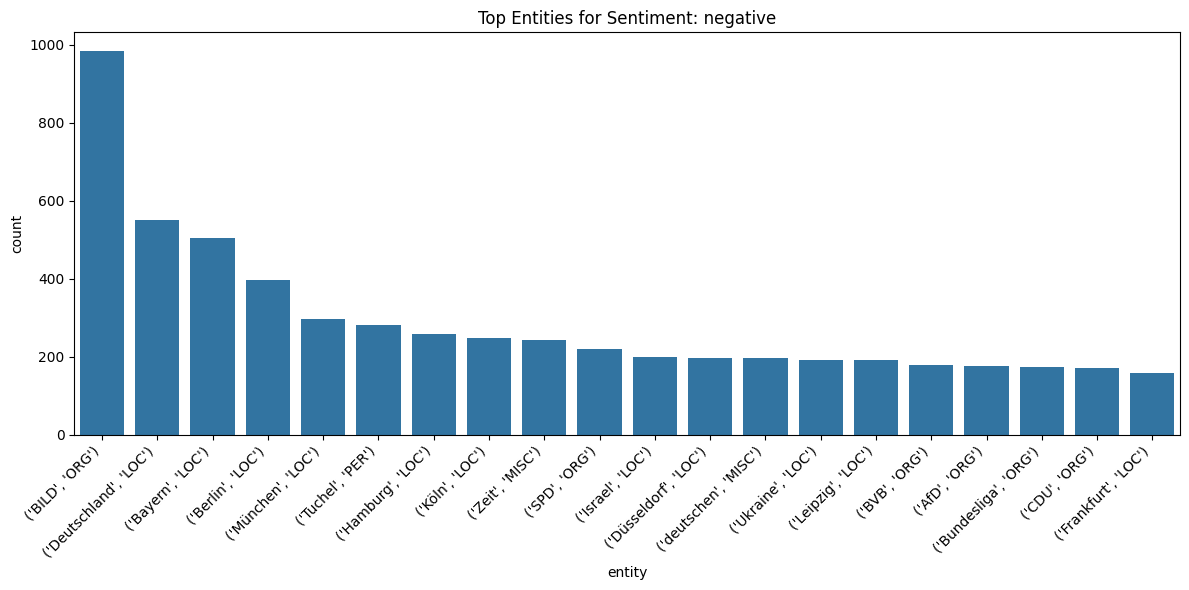

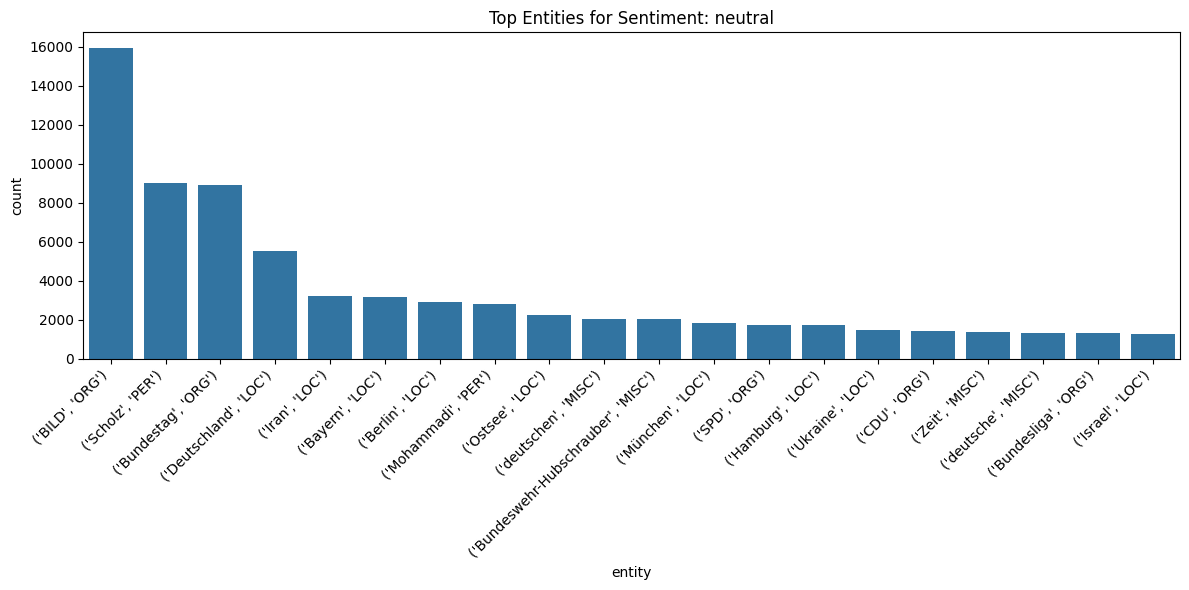

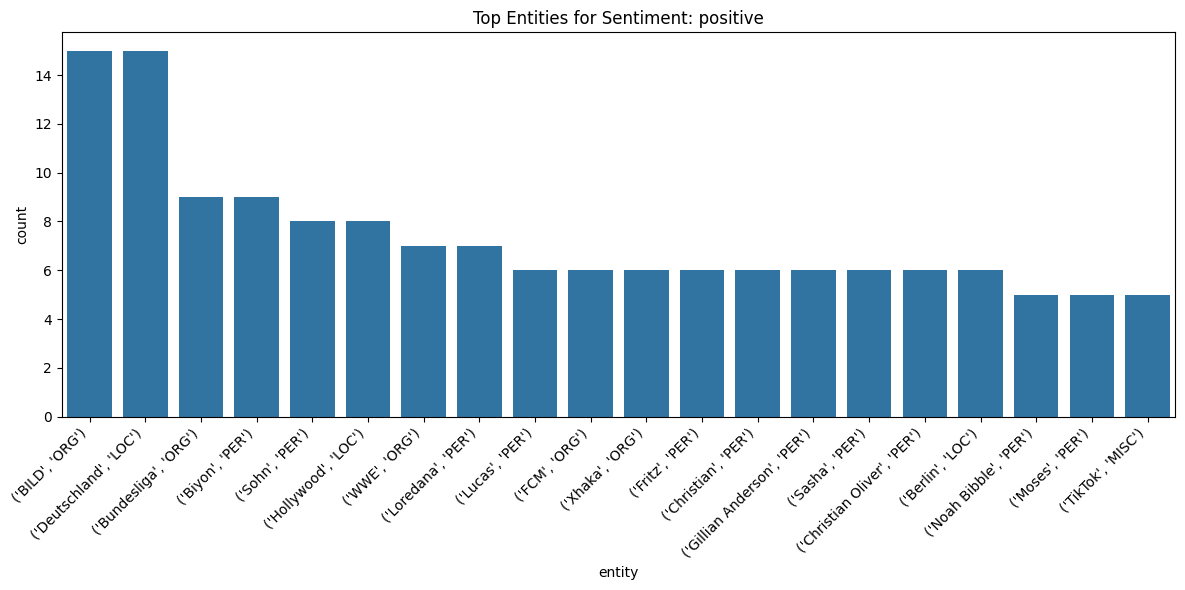

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data for visualization
sentiment_entity_counts = top_1000_entities.groupby(['sentiment', 'entity'])['count'].sum().reset_index()

# Create a plot for each sentiment value
for sentiment in sentiment_entity_counts['sentiment'].unique():
    # Filter data for the current sentiment
    sentiment_data = sentiment_entity_counts[sentiment_entity_counts['sentiment'] == sentiment]

    # Sort the entities by count
    sentiment_data = sentiment_data.sort_values('count', ascending=False).head(20) # Limit to top 20 for clarity

    plt.figure(figsize=(12, 6))  # Adjust figure size for better visualization

    # Convert 'entity' column to string type before plotting
    sentiment_data['entity'] = sentiment_data['entity'].astype(str)

    sns.barplot(x='entity', y='count', data=sentiment_data)
    plt.title(f'Top Entities for Sentiment: {sentiment}')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.show()

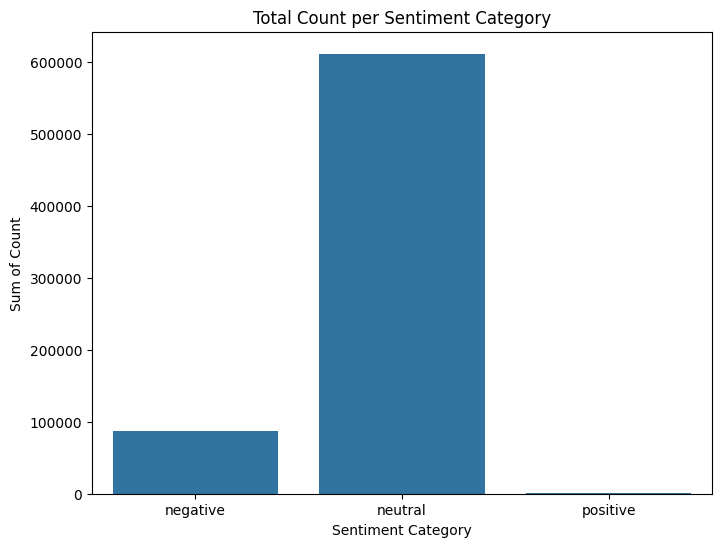

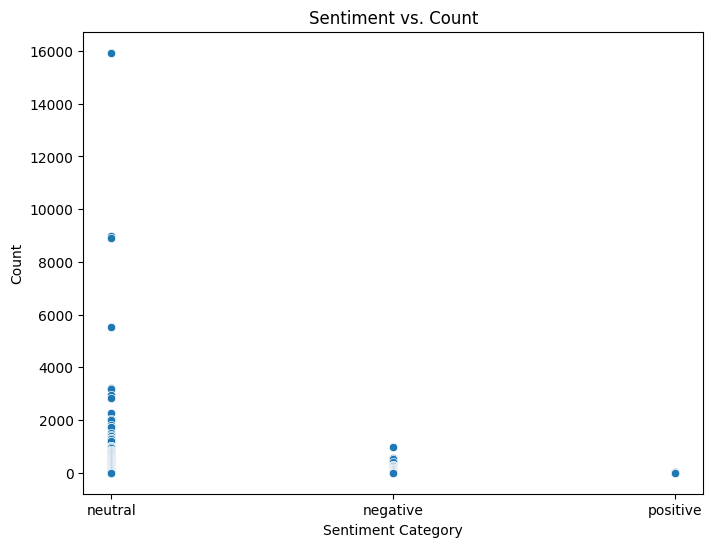

In [138]:
sentiment_counts = new_df.groupby('sentiment')['count'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.title('Total Count per Sentiment Category')
plt.xlabel('Sentiment Category')
plt.ylabel('Sum of Count')
plt.show()

# Scatter plot (if you want to visualize individual entity counts)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment', y='count', data=new_df)
plt.title('Sentiment vs. Count')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

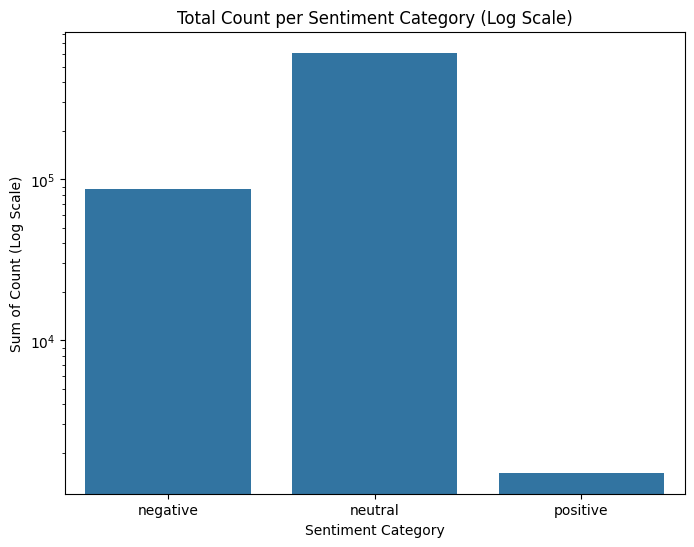

In [139]:
plt.figure(figsize=(8, 6))
sns.barplot(x='sentiment', y='count', data=sentiment_counts)
plt.yscale('log')  # Use log scale for the y-axis
plt.title('Total Count per Sentiment Category (Log Scale)')
plt.xlabel('Sentiment Category')
plt.ylabel('Sum of Count (Log Scale)')
plt.show()

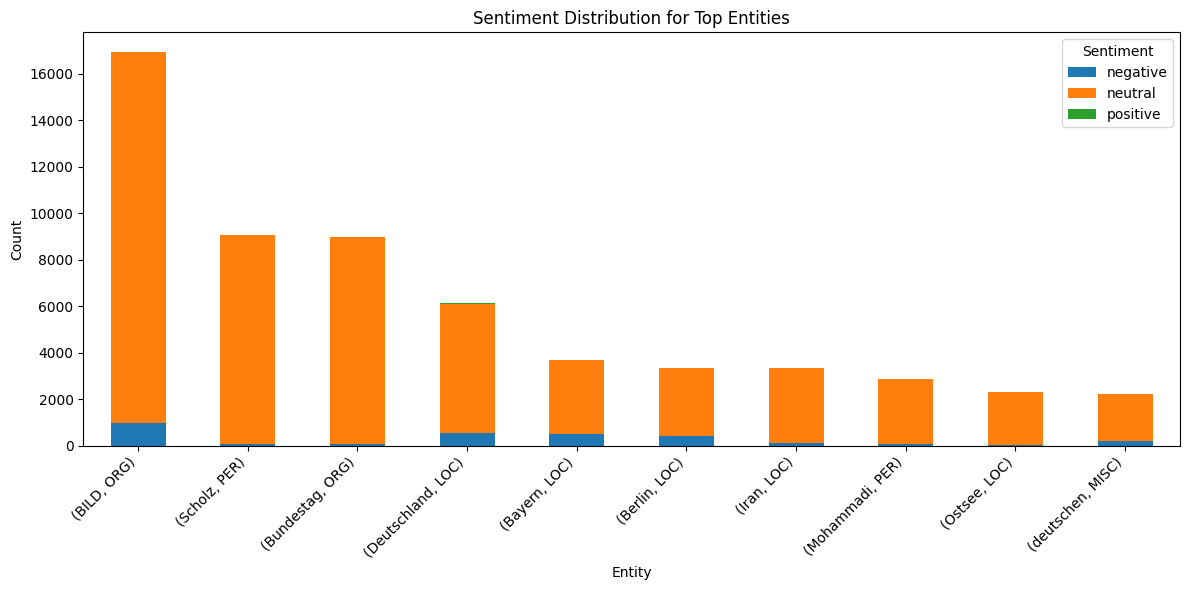

In [141]:

# Group by entity and then unstack for stacked bar plot
entity_sentiment_counts = new_df.groupby(['entity', 'sentiment'])['count'].sum().unstack()

# Filter for entities with a large number of mentions (e.g., top 10)
top_entities = entity_sentiment_counts.sum(axis=1).nlargest(10).index
filtered_entity_sentiment_counts = entity_sentiment_counts.loc[top_entities]

# Create the stacked bar plot
filtered_entity_sentiment_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Distribution for Top Entities')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

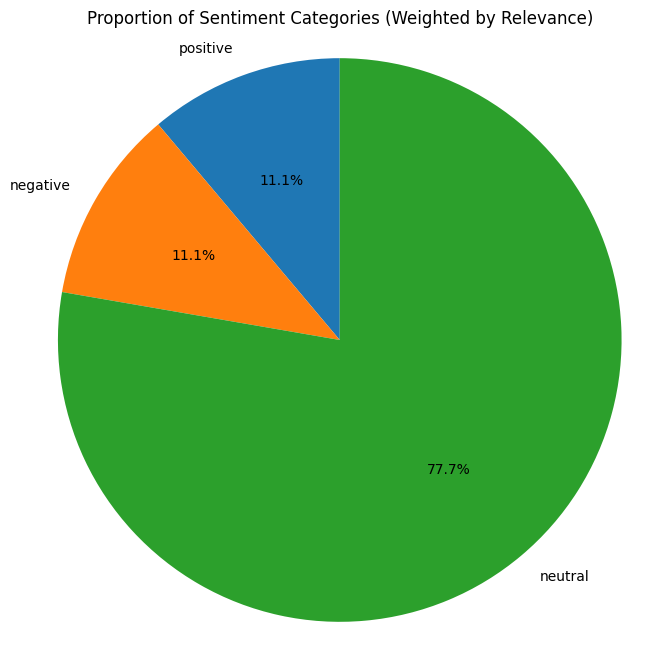

In [145]:
import matplotlib.pyplot as plt


sentiment_counts = pd.DataFrame({
    'sentiment': ['positive', 'negative', 'neutral'],
    'count': [87606, 87606, 611275]
})

plt.figure(figsize=(8, 8))  # Adjust figure size as needed
plt.pie(sentiment_counts['count'], labels=sentiment_counts['sentiment'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Sentiment Categories (Weighted by Relevance)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()